In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.datasets import fetch_openml

In [2]:
def load_mauna_loa_atmospheric_co2():
    ml_data = fetch_openml(data_id=41187)
    months = []
    ppmv_sums = []
    counts = []

    y = ml_data.data.iloc[:, 0]
    m = ml_data.data.iloc[:, 1]
    month_float = y + (m - 1) / 12
    ppmvs = ml_data.target

    for month, ppmv in zip(month_float, ppmvs):
        if not months or month != months[-1]:
            months.append(month)
            ppmv_sums.append(ppmv)
            counts.append(1)
        else:
            # aggregate monthly sum to produce average
            ppmv_sums[-1] += ppmv
            counts[-1] += 1

    months = np.asarray(months).reshape(-1)
    avg_ppmvs = np.asarray(ppmv_sums) / counts
    return months, avg_ppmvs

In [3]:
# load dataset
x, y = load_mauna_loa_atmospheric_co2()

from sklearn import preprocessing
import random

random.seed(23)

idx = random.sample(range(len(x)), 50)

x_new = (x - min(x))/(max(x)-min(x))

scaler = preprocessing.StandardScaler().fit(y.reshape(-1,1))

y_new = scaler.transform(y.reshape(-1,1))


#train_gx = x_new[idx][:,None]
#train_gy = y_new[idx] + 0.0001 * np.random.normal(0,1,50)[:,None]

train_x = x_new[:200][:,None]
train_y = y_new[:200]

test_x = x_new[200:][:,None]
test_y = y_new[200:]

In [4]:
import tensorflow as tf

tf.keras.backend.set_floatx("float64")
tf.get_logger().setLevel("INFO")

In [5]:
import gpflow
import gpflux

num_data = len(train_x)
num_inducing = 49
output_dim = train_y.shape[1]

kernel = gpflow.kernels.SquaredExponential()
inducing_variable = gpflow.inducing_variables.InducingPoints(
    np.linspace(train_x.min(), train_x.max(), num_inducing).reshape(-1, 1)
)
gp_layer = gpflux.layers.GPLayer(
    kernel, inducing_variable, num_data=num_data, num_latent_gps=output_dim
)

In [6]:
num_data, output_dim

(200, 1)

In [7]:
likelihood_layer = gpflux.layers.LikelihoodLayer(gpflow.likelihoods.Gaussian(0.1))

In [8]:
single_layer_dgp = gpflux.models.DeepGP([gp_layer], likelihood_layer)
model = single_layer_dgp.as_training_model()
model.compile(tf.optimizers.Adam(0.01))

Instructions for updating:
Do not pass `graph_parents`.  They will  no longer be used.


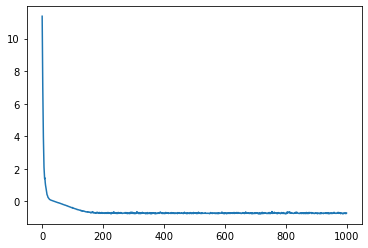

In [9]:
history = model.fit({"inputs": train_x, "targets": train_y}, epochs=int(1e3), verbose=0)
plt.plot(history.history["loss"])

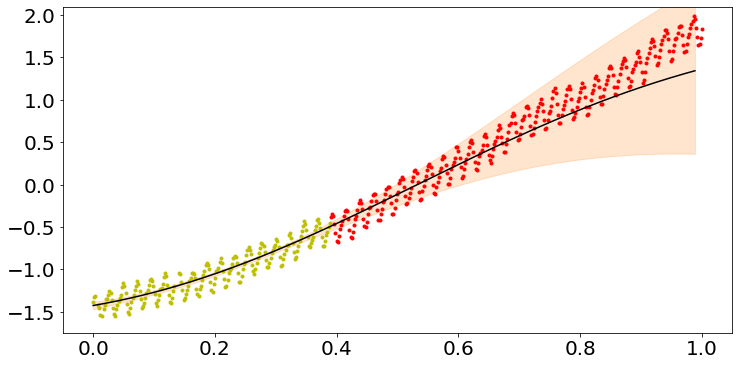

In [10]:
import matplotlib 

matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20) 


def plot(model, X, Y, x_test, y_test, figname, ax=None):
    if ax is None:
        #fig, ax = plt.subplots()
        fig, ax = plt.subplots(figsize=(12, 6))

    a = 0.6
    N_test = 300
    X_test = np.linspace(X.min() , X.max() + a, N_test).reshape(-1, 1)
    out = model(X_test)

    mu = out.f_mean.numpy().squeeze()
    var = out.f_var.numpy().squeeze()
    X_test = X_test.squeeze()
    lower = mu - 1.96 * np.sqrt(var)
    upper = mu + 1.96 * np.sqrt(var)
    
    #ax.rcParams["figure.figsize"] = (20,3)

    ax.set_ylim(Y.min() - 0.2, Y.max() + 2.5)
    ax.plot(X, Y, "y.")
    ax.plot(x_test,y_test,'r.')
    ax.plot(X_test, mu, 'k-',linewidth=1.5)

    ax.fill_between(X_test, lower, upper, color="C1", alpha=0.2)
    fig.savefig(figname, bbox_inches='tight')


plot(single_layer_dgp.as_prediction_model(), train_x[:,0], train_y[:,0], test_x[:,0], test_y[:,0],"gp.pdf")

In [11]:
single_layer_dgp.elbo((train_x, train_y))

<tf.Tensor: shape=(), dtype=float64, numpy=144.80760725472234>

In [12]:
Z = np.linspace(train_x.min(), train_x.max(), num_inducing).reshape(-1, 1)
kernel1 = gpflow.kernels.SquaredExponential()
inducing_variable1 = gpflow.inducing_variables.InducingPoints(Z.copy())
gp_layer1 = gpflux.layers.GPLayer(
    kernel1, inducing_variable1, num_data=num_data, num_latent_gps=output_dim
)

kernel2 = gpflow.kernels.SquaredExponential()
inducing_variable2 = gpflow.inducing_variables.InducingPoints(Z.copy())
gp_layer2 = gpflux.layers.GPLayer(
    kernel2,
    inducing_variable2,
    num_data=num_data,
    num_latent_gps=output_dim,
    mean_function=gpflow.mean_functions.Zero(),
)

kernel3 = gpflow.kernels.SquaredExponential()
inducing_variable3 = gpflow.inducing_variables.InducingPoints(Z.copy())
gp_layer3 = gpflux.layers.GPLayer(
    kernel3,
    inducing_variable3,
    num_data=num_data,
    num_latent_gps=output_dim,
    mean_function=gpflow.mean_functions.Zero(),
)

likelihood_layer = gpflux.layers.LikelihoodLayer(gpflow.likelihoods.Gaussian(0.1))
two_layer_dgp = gpflux.models.DeepGP([gp_layer1, gp_layer2], likelihood_layer)
model = two_layer_dgp.as_training_model()
model.compile(tf.optimizers.Adam(0.01))

In [13]:
history = model.fit({"inputs": train_x, "targets": train_y}, epochs=int(2e3), verbose=0)

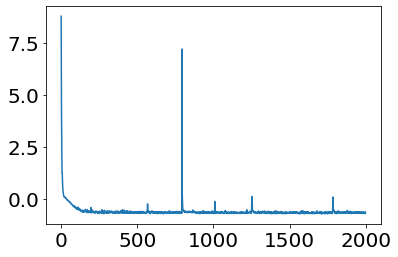

In [14]:
plt.plot(history.history["loss"])

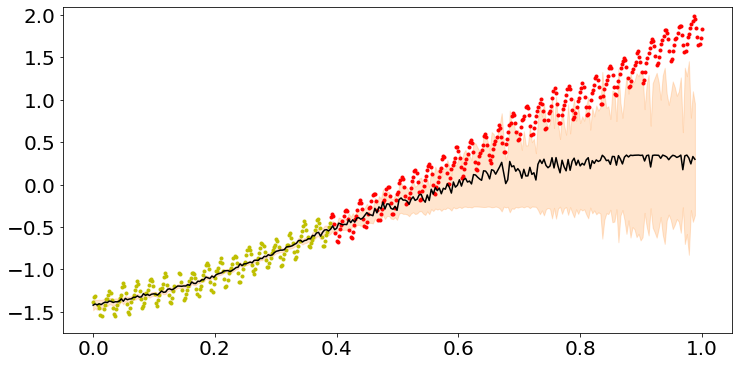

In [15]:
plot(two_layer_dgp.as_prediction_model(), train_x[:,0], train_y[:,0],test_x[:,0],test_y[:,0],'dgp.pdf')

In [16]:
two_layer_dgp.elbo((train_x, train_y))

<tf.Tensor: shape=(), dtype=float64, numpy=135.79767794743196>

In [17]:
three_layer_dgp = gpflux.models.DeepGP([gp_layer1, gp_layer2, gp_layer3], likelihood_layer)
model3 = three_layer_dgp.as_training_model()
model3.compile(tf.optimizers.Adam(0.01))

In [18]:
history = model3.fit({"inputs": train_x, "targets": train_y}, epochs=int(2e3), verbose=0)

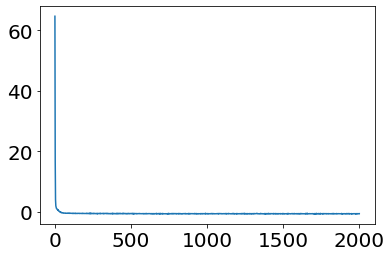

In [19]:
plt.plot(history.history["loss"])

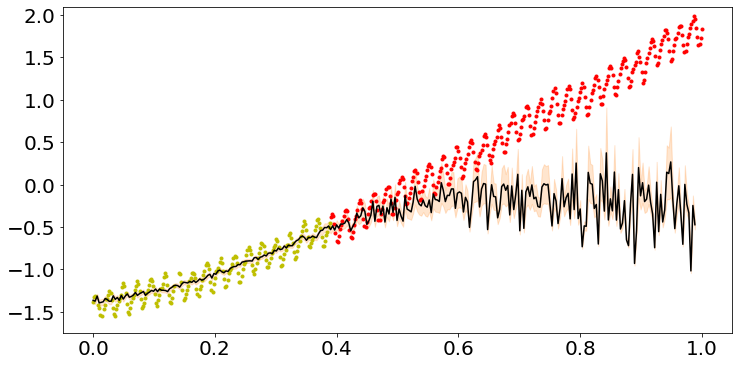

In [20]:
plot(three_layer_dgp.as_prediction_model(), train_x[:,0], train_y[:,0],test_x[:,0],test_y[:,0],'dgp3.pdf')

In [21]:
three_layer_dgp.elbo((train_x, train_y))

<tf.Tensor: shape=(), dtype=float64, numpy=127.46621491335904>

### Deep Kernel learning

In [22]:
num_data, input_dim = train_x.shape

num_data = len(train_x)
num_inducing = 49
output_dim = train_y.shape[1]

kernel = gpflow.kernels.SquaredExponential()
inducing_variable = gpflow.inducing_variables.InducingPoints(
    np.linspace(train_x.min(), train_y.max(), num_inducing).reshape(-1, 1)
)
gp_layer = gpflux.layers.GPLayer(
    kernel, inducing_variable, num_data=num_data, num_latent_gps=output_dim
)

In [23]:
likelihood = gpflow.likelihoods.Gaussian(0.001)

# So that Keras can track the likelihood variance, we need to provide the likelihood as part of a "dummy" layer:
likelihood_container = gpflux.layers.TrackableLayer()
likelihood_container.likelihood = likelihood

model_dkl = tf.keras.Sequential(
    [
        tf.keras.layers.Dense(100, activation="relu"),
        tf.keras.layers.Dense(100, activation="relu"),
        tf.keras.layers.Dense(1, activation="linear"),
        gp_layer,
        likelihood_container,  # no-op, for discovering trainable likelihood parameters
    ]
)
loss = gpflux.losses.LikelihoodLoss(likelihood)

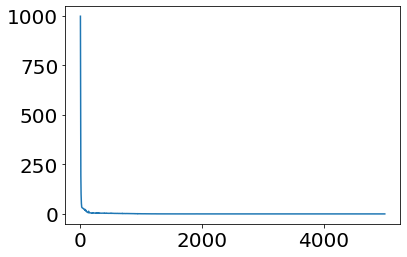

In [24]:
model_dkl.compile(loss=loss, optimizer="adam")
hist = model_dkl.fit(train_x, train_y, epochs=5000, verbose=0)
plt.plot(hist.history["loss"])

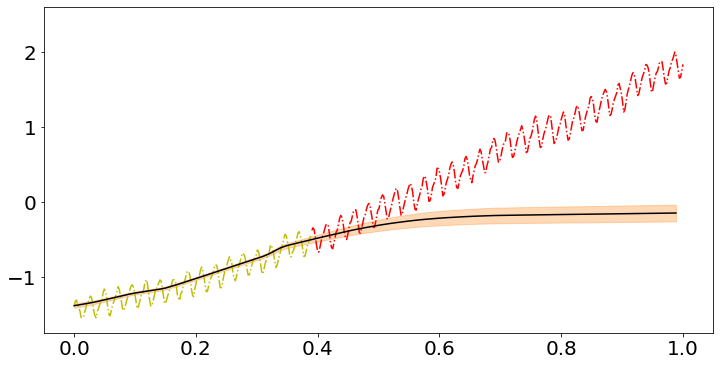

In [25]:
import matplotlib 

matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20) 

def plot(model, X, Y, test_x, test_y, figname, ax=None):
    if ax is None:
        #fig, ax = plt.subplots()
        fig, ax = plt.subplots(figsize=(12, 6))
    

    x_margin = 0.6
    N_test = 100
    X_test = np.linspace(X.min() , X.max() + x_margin, N_test).reshape(-1, 1)
    f_distribution = model(X_test)

    mean = f_distribution.mean().numpy().squeeze()
    var = f_distribution.variance().numpy().squeeze()
    X_test = X_test.squeeze()
    lower = mean - 2 * np.sqrt(var)
    upper = mean + 2 * np.sqrt(var)

    ax.set_ylim(Y.min() - 0.2, Y.max() + 3.0)
    ax.plot(X, Y, "y-.", linewidth=1.5)
    ax.plot(test_x, test_y, "r-.", linewidth=1.5)
    ax.plot(X_test, mean, 'k-', linewidth=1.5)

    ax.fill_between(X_test, lower, upper, color="C1", alpha=0.3)
    fig.savefig(figname, bbox_inches='tight')


plot(model_dkl, train_x, train_y, test_x, test_y, 'co2_dkl.pdf')